# Lasso, Ridge and Polynomial Linear Regression

In [1]:
# Imports
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Preprocessing
from transformers import AverageTransformer, DateTransformer, CyclicalTransformer, SimpleDateTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV
from functions import learning_curves
from sklearn.ensemble import BaggingRegressor

In [3]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='viridis', rc={"axes.spines.right": False, "axes.spines.top": False})

In [4]:
# Data
X = pd.read_csv('data/train.csv')
y = X['TARGET_energy']
X.drop(columns=['TARGET_energy'], inplace=True)
X.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,54.264286,9.963333,92.656667,17.70,39.663333,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000,48.717990,48.717990
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,48.961111,6.466667,99.900000,15.69,38.090000,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333,42.204855,42.204855
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,45.090000,10.566667,37.993333,19.89,33.900000,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667,40.133645,40.133645
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,59.102222,8.926667,64.193333,18.79,37.637778,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333,24.570344,24.570344
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,41.290000,16.430000,1.000000,22.20,32.441429,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667,18.195913,18.195913


## Evaluation Framework

In [5]:
# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Evaluation
from functions import residual_plots, learning_curves

# Scoring Metrics
rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
r2 = make_scorer(r2_score)

## Preprocessing

In [6]:
# Drop redundant features
drop = ('drop', ['rv1', 'rv2'])

# Transformation Columns for Average Transform
T_cols = [col for col in X.columns if re.search('T\d', col)]
RH_cols = [col for col in X.columns if re.search('RH_[1-4,7-9]', col)]

# Transformations
dt = DateTransformer(['date'])
ct = CyclicalTransformer(['date'])
sdt = SimpleDateTransformer(['date'])
t_at = AverageTransformer(T_cols, ['T_avg'])
rh_at = AverageTransformer(RH_cols, ['RH_avg'])

In [7]:
# Scalers
ss = StandardScaler()
pt = PowerTransformer()
qt = QuantileTransformer()

In [8]:
# Models
lr = LinearRegression()
l1 = Lasso()
l2 = Ridge()
en = ElasticNet()
pf = PolynomialFeatures(degree=2, include_bias=True)

## Lasso Regression
Lasso regression adds a regularisation term to the cost function, using the l1 norm. An important feature of Lasso reegression is that it tends to remove unimportant feature by setting their coefficients to 0, thereby performing feature selection. 

In [9]:
l1_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')
l1_pipeline = make_pipeline(l1_preprocess, ss, l1)

params = [{
    'lasso':[l1]
}]

l1_gs = GridSearchCV(l1_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l1_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid=[{'lasso': [Lasso()]}], refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [10]:
# Best model so far
l1_best = l1_gs.best_estimator_

In [11]:
rmse_loss = max(l1_gs.cv_results_['mean_test_rmse'])
r2_score = max(l1_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -93.491
average r squared: 0.183


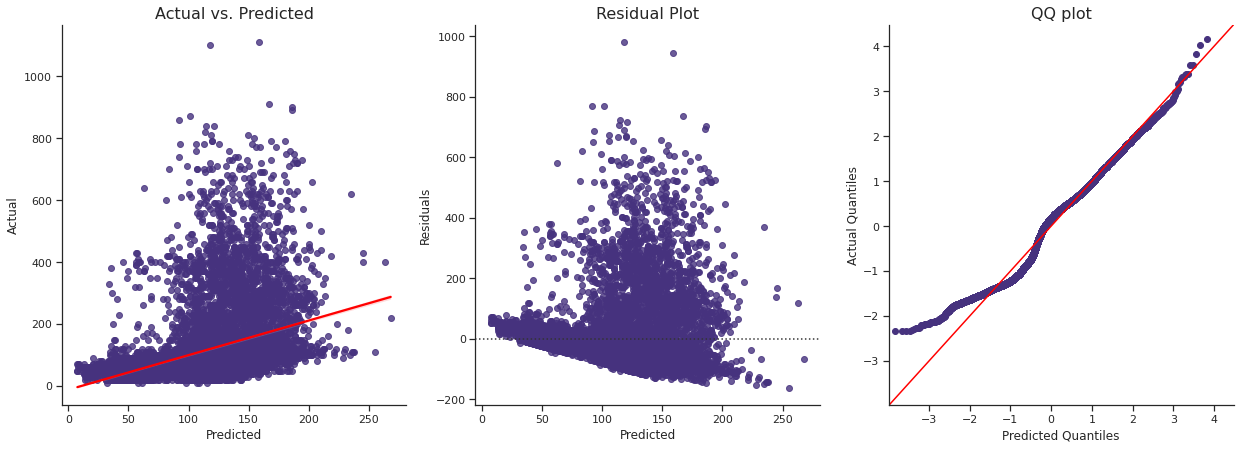

In [12]:
residual_plots(l1_best, X, y)

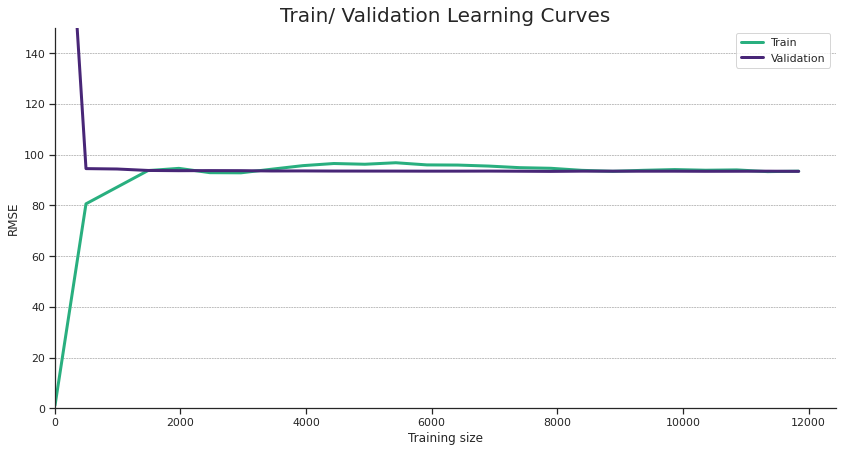

In [13]:
learning_curves(l1_best, X, y)

The residual plots and learning curves look similar to the baseline linear regression model, which is to be expected. Regularisaton tends to resolve overfitting, however, the data seems to be well fit due to the low generalisation gap, albeit not a good model due to the high error score. 

#### Hyperparameter Tuning

In [14]:
params = [{
    'lasso__alpha': np.linspace(0.01,0.1,20)
}]

l1_gs = GridSearchCV(l1_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l1_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid=[{'lasso__alpha': array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [15]:
l1_results = pd.DataFrame(l1_gs.cv_results_)[['param_lasso__alpha', 'mean_test_rmse', 'mean_test_r2']]
l1_results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
l1_results[:10]

,param_lasso__alpha,mean_test_rmse,mean_test_r2
2,0.019474,-92.212971,0.204481
3,0.024211,-92.212996,0.204482
4,0.028947,-92.213108,0.204482
1,0.014737,-92.213186,0.204475
5,0.033684,-92.213267,0.204482
6,0.038421,-92.213548,0.204479
0,0.01,-92.213636,0.204466
7,0.043158,-92.213997,0.204473
8,0.047895,-92.214484,0.204466
9,0.052632,-92.215446,0.204452


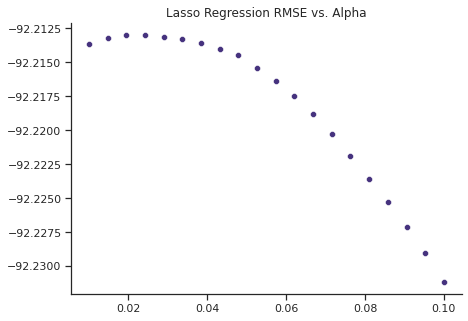

In [16]:
fig = plt.figure(figsize=(7,5))

sns.scatterplot(x=l1_gs.cv_results_['param_lasso__alpha'] ,y=l1_gs.cv_results_['mean_test_rmse'])

plt.title('Lasso Regression RMSE vs. Alpha')
plt.show()


In [17]:
params = [{
    'lasso__alpha': np.linspace(0.01,0.03,20)
}]

l1_gs = GridSearchCV(l1_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l1_gs.fit(X, y)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid=[{'lasso__alpha': array([0.01      , 0.01105263, 0.01210526, 0.01315789, 0.01421053,
       0.01526316, 0.01631579, 0.01736842, 0.01842105, 0.01947368,
       0.02052632, 0.02157895, 0.02263158, 0.02368421, 0.02473684,
       0.02578947, 0.02684211, 0.02789474, 0.02894737, 0.03      ])}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

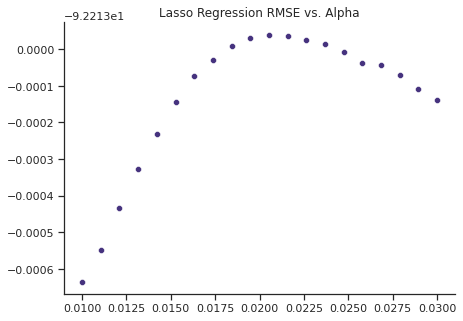

In [18]:
fig = plt.figure(figsize=(7,5))

sns.scatterplot(x=l1_gs.cv_results_['param_lasso__alpha'] ,y=l1_gs.cv_results_['mean_test_rmse'])

plt.title('Lasso Regression RMSE vs. Alpha')
plt.show()

In [19]:
l1_results = pd.concat([l1_results, pd.DataFrame(l1_gs.cv_results_)[['param_lasso__alpha', 'mean_test_rmse', 'mean_test_r2']]], ignore_index=True)
l1_results[:10]

,param_lasso__alpha,mean_test_rmse,mean_test_r2
0,0.019474,-92.212971,0.204481
1,0.024211,-92.212996,0.204482
2,0.028947,-92.213108,0.204482
3,0.014737,-92.213186,0.204475
4,0.033684,-92.213267,0.204482
5,0.038421,-92.213548,0.204479
6,0.01,-92.213636,0.204466
7,0.043158,-92.213997,0.204473
8,0.047895,-92.214484,0.204466
9,0.052632,-92.215446,0.204452


In [20]:
# Best model so far
l1_best = l1_gs.best_estimator_

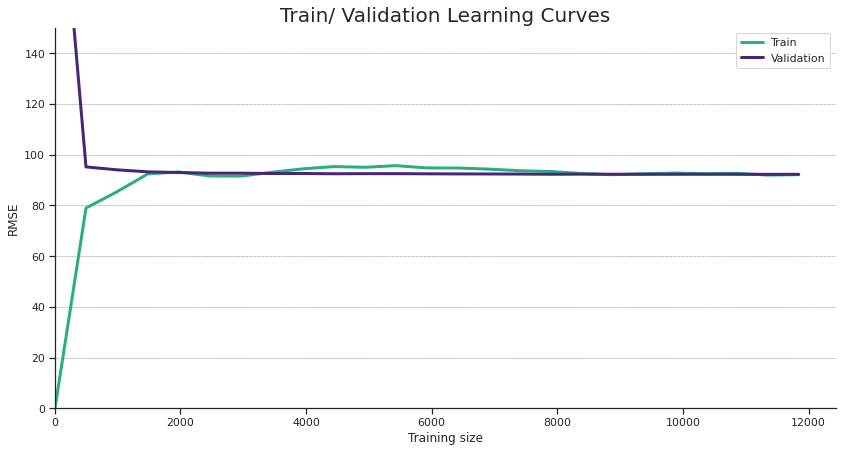

In [21]:
learning_curves(l1_best, X, y)

In [22]:
params = [{
    'columntransformer__cyclicaltransformer': [dt, sdt, ct],
    'standardscaler' :[ss, pt, qt],
    'lasso__alpha': [0.2]
}]

l1_gs = GridSearchCV(l1_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l1_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid=[{'columntransformer__cyclicaltransformer': [DateTransformer(date=['date']),
                                                                     SimpleDateTransformer(date=['date']),
                                                                     CyclicalTransformer(cyclical_features=['date'])],
                          'lasso__alpha': [0.2],
                          'standardscaler': [StandardScaler(),
                                             PowerTransformer(),
                                             QuantileTransformer()]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [23]:
pd.DataFrame(l1_gs.cv_results_)[['param_standardscaler', 'param_columntransformer__cyclicaltransformer', 'mean_test_rmse', 'mean_test_r2']]

,param_standardscaler,param_columntransformer__cyclicaltransformer,mean_test_rmse,mean_test_r2
0,StandardScaler(),DateTransformer(date=['date']),-92.579560,0.198223
1,PowerTransformer(),DateTransformer(date=['date']),-92.930231,0.192184
2,QuantileTransformer(),DateTransformer(date=['date']),-93.670709,0.179377
3,StandardScaler(),SimpleDateTransformer(date=['date']),-92.644053,0.197154
4,PowerTransformer(),SimpleDateTransformer(date=['date']),-93.030838,0.190483
5,QuantileTransformer(),SimpleDateTransformer(date=['date']),-93.937090,0.174769
6,StandardScaler(),CyclicalTransformer(cyclical_features=['date']),-92.285473,0.203313
7,PowerTransformer(),CyclicalTransformer(cyclical_features=['date']),-92.683957,0.196460
8,QuantileTransformer(),CyclicalTransformer(cyclical_features=['date']),-93.411129,0.183911


The best model using lasso regression seems to be a slight adjustment of the alpha value, without any further preprocessing performed on the dataset. The model generalises well, however, still has high RMSE.


In [24]:
filename = 'models/l1_best.sav'
joblib.dump(l1_best, filename)

['models/l1_best.sav']

## Ridge Regression
Ridge regression regularises the model through the hyperparamter lamba (alpha), which inversely relates to the strength of the regularisation as lambda increases to infinity. Ridge regression works by adding a term to the cost function, by which the algorithm learns to fit the model with the smallest coefficient weights as possible. The closer to infinity lambda gets, the model becomes closer to the mean of the data.

In [25]:
l2_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')
l2_pipeline = make_pipeline(l2_preprocess, ss, l2)

params = [{
    'ridge': [l2],
}]

l2_gs = GridSearchCV(l2_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l2_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1, param_grid=[{'ridge': [Ridge()]}], refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [26]:
# Best model so far
l2_best = l2_gs.best_estimator_

In [27]:
rmse_loss = max(l2_gs.cv_results_['mean_test_rmse'])
r2_score = max(l2_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -92.285
average r squared: 0.203


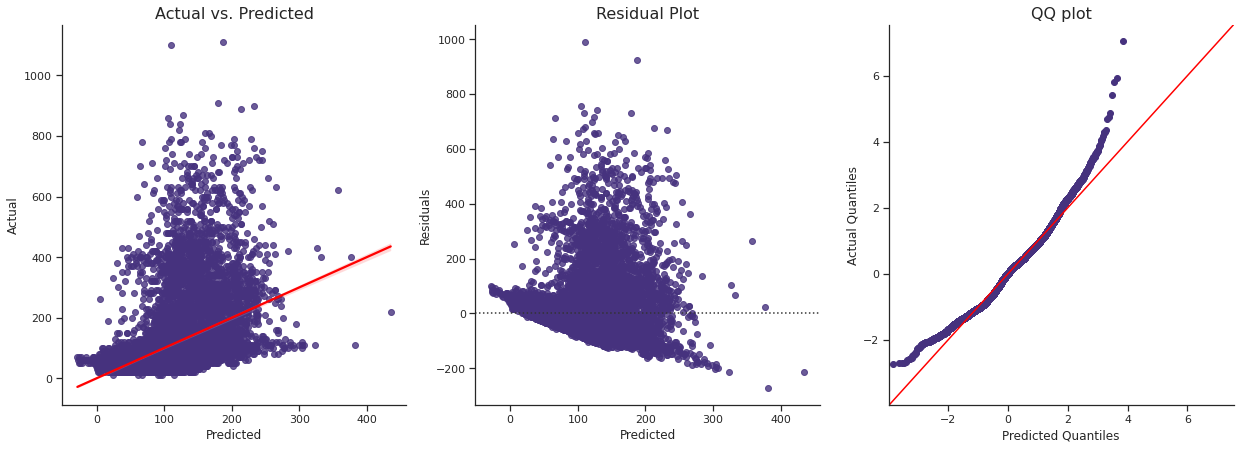

In [28]:
residual_plots(l2_best, X, y)

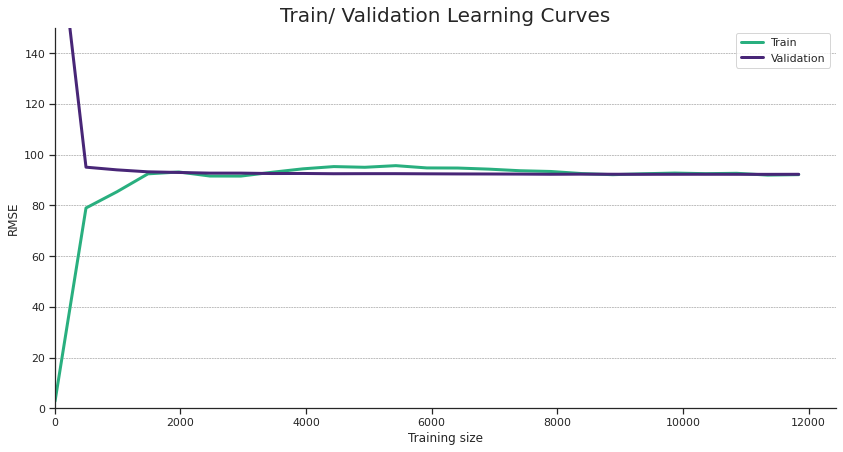

In [29]:
learning_curves(l2_best, X, y)

Similar story to the lasso model, however, performs slighlty better. Well generalised, however, high RMSE loss.

#### Hyperparameter Tuning

In [30]:
params = [{
    'ridge__alpha':np.linspace(1,100, 25)
}]

l2_gs = GridSearchCV(l2_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l2_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid=[{'ridge__alpha': array([  1.   ,   5.125,   9.25 ,  13.375,  17.5  ,  21.625,  25.75 ,
        29.875,  34.   ,  38.125,  42.25 ,  46.375,  50.5  ,  54.625,
        58.75 ,  62.875,  67.   ,  71.125,  75.25 ,  79.375,  83.5  ,
        87.625,  91.75 ,  95.875, 100.   ])}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [31]:
l2_results = pd.DataFrame(l2_gs.cv_results_)[['param_ridge__alpha', 'mean_test_rmse', 'mean_test_r2']]
l2_results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
l2_results[:10]

,param_ridge__alpha,mean_test_rmse,mean_test_r2
2,9.25,-92.211694,0.204504
3,13.375,-92.211825,0.204505
1,5.125,-92.212175,0.204492
4,17.5,-92.212499,0.204497
0,1.0,-92.213351,0.204468
5,21.625,-92.213657,0.204481
6,25.75,-92.215253,0.204456
7,29.875,-92.217243,0.204426
8,34.0,-92.219591,0.204388
9,38.125,-92.222266,0.204346


In [32]:
# Best model so far
l2_best = l2_gs.best_estimator_

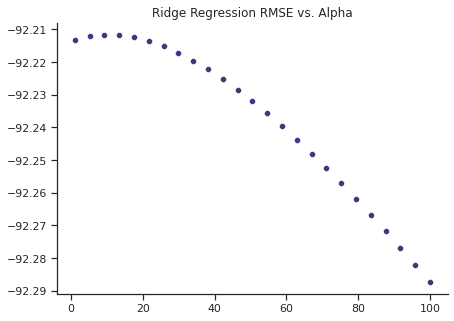

In [33]:
fig = plt.figure(figsize=(7,5))

sns.scatterplot(x=l2_gs.cv_results_['param_ridge__alpha'] ,y=l2_gs.cv_results_['mean_test_rmse'])

plt.title('Ridge Regression RMSE vs. Alpha')
plt.show()

In [34]:
params = [{
    'ridge__alpha':np.linspace(5, 20, 30)
}]

l2_gs = GridSearchCV(l2_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l2_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid=[{'ridge__alpha': array([ 5.        ,  5.51724138...
       10.17241379, 10.68965517, 11.20689655, 11.72413793, 12.24137931,
       12.75862069, 13.27586207, 13.79310345, 14.31034483, 14.82758621,
       15.34482759, 15.86206897, 16.37931034, 16.89655172, 17.4137931 ,
       17.93103448, 18.44827586, 18.96551724, 19.48275862, 20.        ])}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [35]:
l2_results = pd.DataFrame(l2_gs.cv_results_)[['param_ridge__alpha', 'mean_test_rmse', 'mean_test_r2']]
l2_results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
l2_results[:10]

,param_ridge__alpha,mean_test_rmse,mean_test_r2
10,10.172414,-92.211673,0.204505
11,10.689655,-92.211675,0.204505
9,9.655172,-92.211681,0.204504
12,11.206897,-92.211685,0.204506
8,9.137931,-92.211699,0.204504
13,11.724138,-92.211704,0.204506
7,8.62069,-92.211726,0.204503
14,12.241379,-92.211733,0.204506
6,8.103448,-92.211763,0.204502
15,12.758621,-92.211770,0.204506


In [36]:
# Best model so far
l2_best = l2_gs.best_estimator_

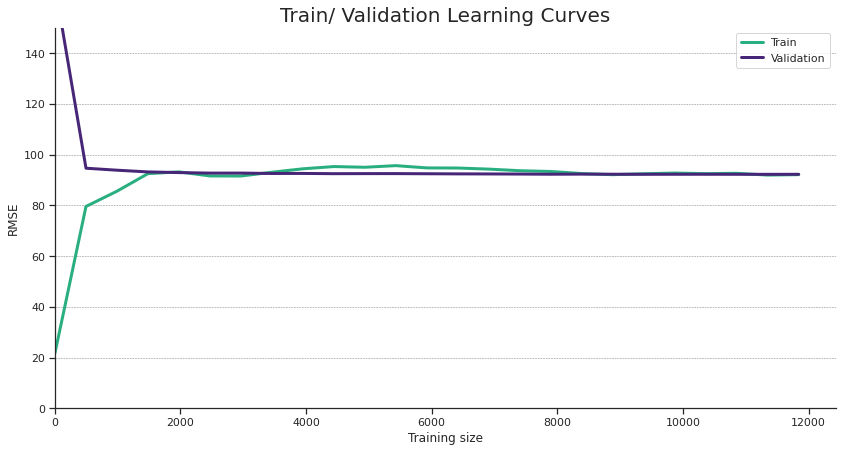

In [37]:
learning_curves(l2_best, X, y)

In [38]:
params = [{
    'columntransformer__cyclicaltransformer':[dt, sdt, ct],
    'standardscaler':[pt, ss, qt],
    'ridge__alpha':[10.1]
}]

l2_gs = GridSearchCV(l2_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
l2_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid=[{'columntransformer__cyclicaltransformer': [DateTransformer(date=['date']),
                                                                     SimpleDateTransformer(date=['date']),
                                                                     CyclicalTransformer(cyclical_features=['date'])],
                          'ridge__alpha': [10.1],
                          'standardscaler': [PowerTransformer(),
                                             StandardScaler(),
                                             QuantileTransformer()]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [39]:
l2_results = pd.DataFrame(l2_gs.cv_results_)[['param_ridge__alpha', 'param_standardscaler', 'param_columntransformer__cyclicaltransformer', 'mean_test_rmse', 'mean_test_r2']]
l2_results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
l2_results[:10]

,param_ridge__alpha,param_standardscaler,param_columntransformer__cyclicaltransformer,mean_test_rmse,mean_test_r2
7,10.1,StandardScaler(),CyclicalTransformer(cyclical_features=['date']),-92.211674,0.204505
1,10.1,StandardScaler(),DateTransformer(date=['date']),-92.506277,0.199421
4,10.1,StandardScaler(),SimpleDateTransformer(date=['date']),-92.569148,0.198385
6,10.1,PowerTransformer(),CyclicalTransformer(cyclical_features=['date']),-92.616656,0.197547
0,10.1,PowerTransformer(),DateTransformer(date=['date']),-92.867035,0.193218
3,10.1,PowerTransformer(),SimpleDateTransformer(date=['date']),-92.955814,0.191732
8,10.1,QuantileTransformer(),CyclicalTransformer(cyclical_features=['date']),-92.974357,0.191400
2,10.1,QuantileTransformer(),DateTransformer(date=['date']),-93.263413,0.186380
5,10.1,QuantileTransformer(),SimpleDateTransformer(date=['date']),-93.538706,0.181674


Ridge regression did not do much better than lasso regression.

In [40]:
filename = 'models/l2_best.sav'
joblib.dump(l2_best, filename)

['models/l2_best.sav']

## Elastic Net
Elastic Net is the middle ground between Lasso regularisation and Ridge regularisation. The regularisation term is a mix of both Ridge and Lasso. As there is signficant multicollinearity between features, yet there are only a handful of seeming important features, Elastic Net should perform better than both Ridge and Lasso.

In [41]:
en_preprocess = make_column_transformer(drop, (ct, ['date']), remainder='passthrough')
en_pipeline = make_pipeline(en_preprocess, ss, en)

params = [{
    'elasticnet': [en],
}]

en_gs = GridSearchCV(en_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
en_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1, param_grid=[{'elasticnet': [ElasticNet()]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [42]:
# Best model so far
en_best = en_gs.best_estimator_

In [43]:
rmse_loss = max(en_gs.cv_results_['mean_test_rmse'])
r2_score = max(en_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -92.285
average r squared: 0.203


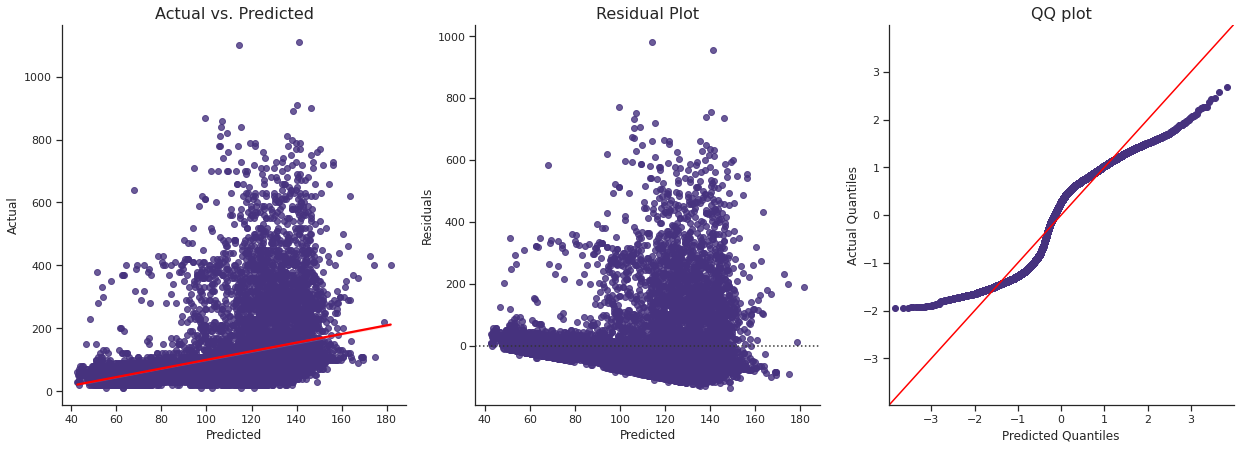

In [44]:
residual_plots(en_best, X, y)

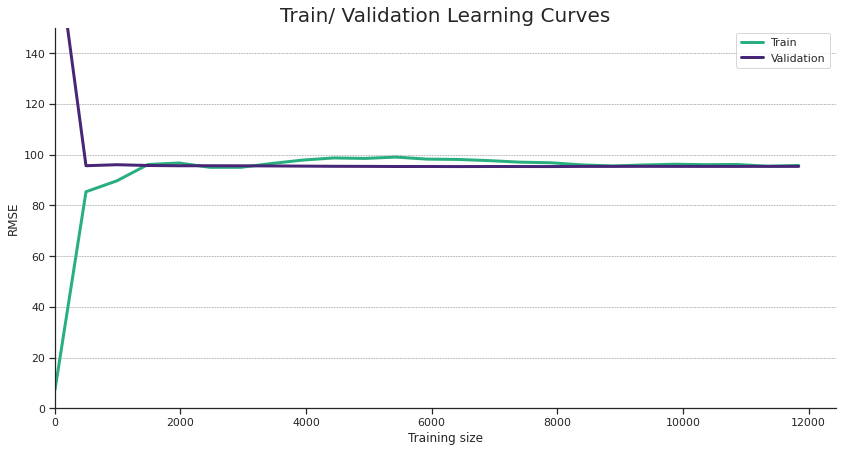

In [45]:
learning_curves(en_best, X, y)

As predicted, ElasticNet does not do any better than other regularisation techniques.

#### Hyperparameter Tuning

In [46]:
params = [{
    'elasticnet__l1_ratio': np.linspace(0.1,1,10),
    'elasticnet__alpha': np.logspace(0.1, 10, 10)
}]

en_gs = GridSearchCV(en_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
en_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid=[{'elasticnet__alpha': array...25892541e+00, 1.58489319e+01, 1.99526231e+02, 2.51188643e+03,
       3.16227766e+04, 3.98107171e+05, 5.01187234e+06, 6.30957344e+07,
       7.94328235e+08, 1.00000000e+10]),
                          'elasticnet__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [47]:
en_results = pd.DataFrame(en_gs.cv_results_)[['param_elasticnet__l1_ratio', 'param_elasticnet__alpha', 'mean_test_rmse', 'mean_test_r2']]
en_results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)
en_results[:10]

,param_elasticnet__l1_ratio,param_elasticnet__alpha,mean_test_rmse,mean_test_r2
9,1.0,1.258925,-93.869138,0.175908
8,0.9,1.258925,-94.728599,0.160764
7,0.8,1.258925,-95.140646,0.153454
6,0.7,1.258925,-95.449513,0.147957
5,0.6,1.258925,-95.708667,0.143333
4,0.5,1.258925,-95.934437,0.139295
3,0.4,1.258925,-96.136728,0.135666
2,0.3,1.258925,-96.319288,0.132383
1,0.2,1.258925,-96.487908,0.129344
0,0.1,1.258925,-96.644958,0.126509


Not worth including Elastic Net, as it seems to converge to a ratio using purely lasso regression.

## Polynomial Regression
As the data does not seem to follow a linear realtionship, it might be worth trying Polynomial Linear Regression, adding combinations of features to the nth power. We will stop at the third degree, as there are already many features, the compute will take too long and we don't want to overfit the data. We will need to adjust the pipeline to include a polynomial transformation.

In [48]:
pr_preprocess = make_column_transformer(drop, (ct, ['date']), (t_at, T_cols), (rh_at, RH_cols), ('drop', T_cols+RH_cols), remainder='passthrough')
pr_pipeline = make_pipeline(pr_preprocess, pf, ss, lr)

params = [{
    'columntransformer__averagetransformer-1':['passthrough'],
    'columntransformer__averagetransformer-2':['passthrough'],
    'columntransformer__drop-2':['passthrough']
}]

pr_gs = GridSearchCV(pr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
pr_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop-1',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date']),
                                                                        ('averagetransformer-1',
                                                                         AverageTransformer(column_name=['T_avg'],
                                                                                            features=['T1',
                                                                                                      'T2',
                                                                                                      'T3',
                                                                                                      'T4',
                                                                                                      'T5',
                                                                                                      'T6',
                                                                                                      'T7',
                                                                                                      'T8',...
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'columntransformer__averagetransformer-1': ['passthrough'],
                          'columntransformer__averagetransformer-2': ['passthrough'],
                          'columntransformer__drop-2': ['passthrough']}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [49]:
rmse_loss = max(pr_gs.cv_results_['mean_test_rmse'])
r2_score = max(pr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -92.285
average r squared: 0.203


In [50]:
# Best model so far
pr_best = pr_gs.best_estimator_

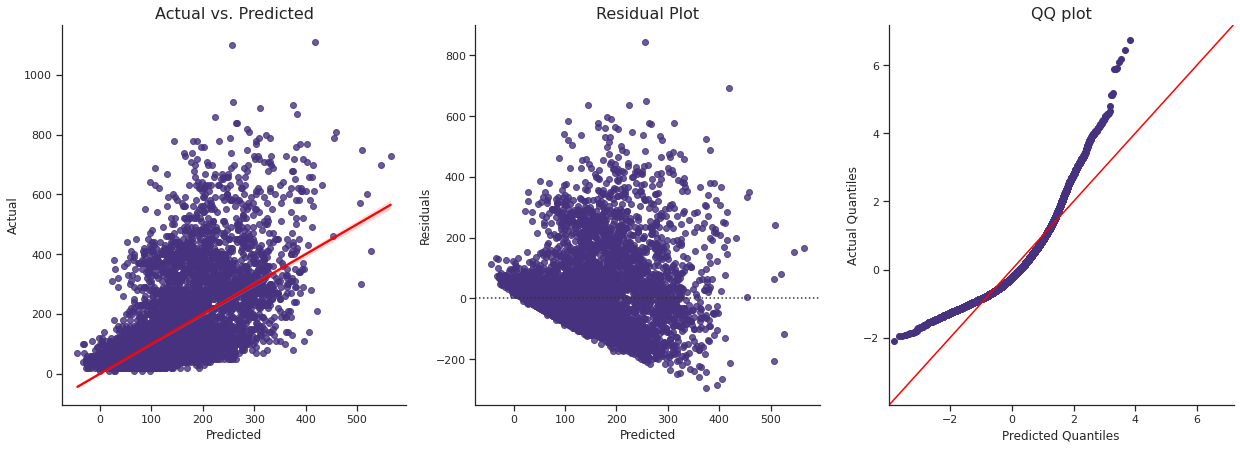

In [51]:
residual_plots(pr_best, X, y)

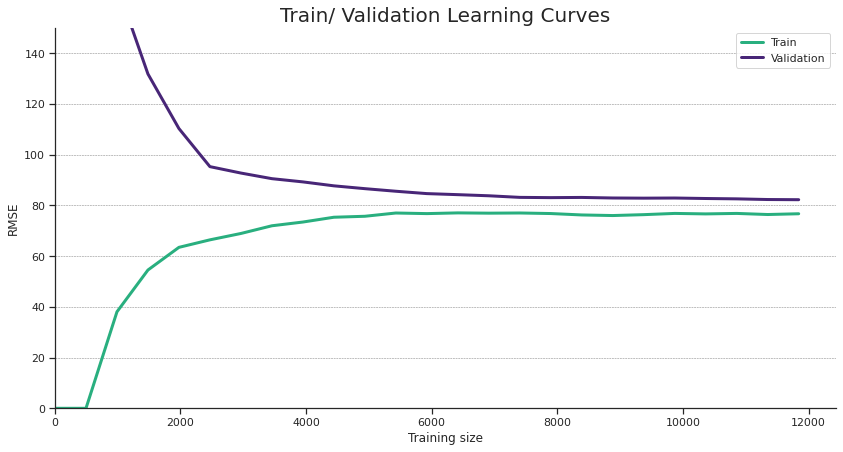

In [52]:
learning_curves(pr_best, X, y)

Although the residuals and q-q plot don't look optimal, using polynomial features in the linear regression seems to have resulted in a big improvement in reducing the RMSE loss function. The model is also able to explain around 37% of the data variance. Positively, the generalisation gap is stable, where the model has relatively high bias. Attempting to to increase the complexity of the model by another degree involves reducing some of the input features, due to CPU and RAM resourcing issues. 

In [53]:
params = [{
    'polynomialfeatures__degree':[3]
}]

pr_gs = GridSearchCV(pr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=4, cv=5)
pr_gs.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop-1',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date']),
                                                                        ('averagetransformer-1',
                                                                         AverageTransformer(column_name=['T_avg'],
                                                                                            features=['T1',
                                                                                                      'T2',
                                                                                                      'T3',
                                                                                                      'T4',
                                                                                                      'T5',
                                                                                                      'T6',
                                                                                                      'T7',
                                                                                                      'T8',
                                                                                                      '...
                                                                          'RH_2',
                                                                          'RH_3',
                                                                          'RH_4',
                                                                          'RH_7',
                                                                          'RH_8',
                                                                          'RH_9'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=4, param_grid=[{'polynomialfeatures__degree': [3]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [54]:
rmse_loss = max(pr_gs.cv_results_['mean_test_rmse'])
r2_score = max(pr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -92.285
average r squared: 0.203


In [55]:
# Best model so far
pr_best = pr_gs.best_estimator_

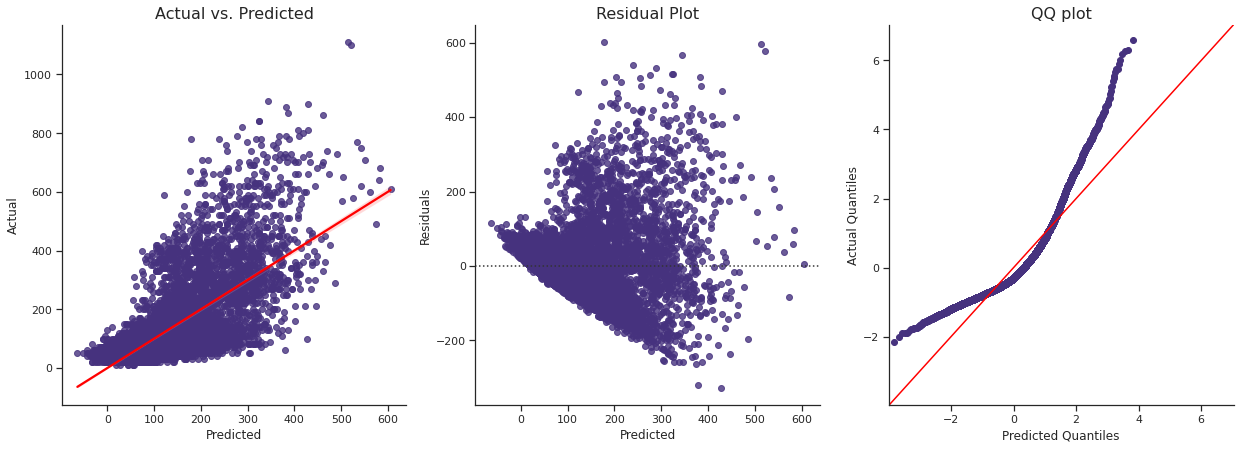

In [56]:
residual_plots(pr_best, X, y)

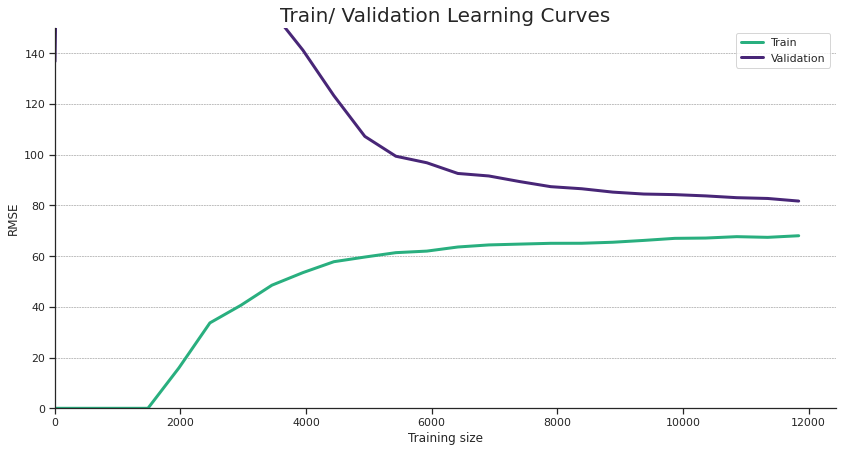

In [57]:
learning_curves(pr_best, X, y)

The learning curve chart above indicates that the model is starting to overfit the data, shown by the larger generalisation gap. The training and validation error curves also do not seem to have stabilised, indicating that there is still room for improvement with this model by increasing the amount of training samples. The q-q plot indicates that the data starts to overestimate values toward the upper tails.

In [58]:
params = [{
    'polynomialfeatures__degree':[3],
    'linearregression' :[l1, l2]
}]

pr_gs = GridSearchCV(pr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=4, cv=5)
pr_gs.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop-1',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date']),
                                                                        ('averagetransformer-1',
                                                                         AverageTransformer(column_name=['T_avg'],
                                                                                            features=['T1',
                                                                                                      'T2',
                                                                                                      'T3',
                                                                                                      'T4',
                                                                                                      'T5',
                                                                                                      'T6',
                                                                                                      'T7',
                                                                                                      'T8',
                                                                                                      '...
                                                                          'RH_9'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=4,
             param_grid=[{'linearregression': [Lasso(), Ridge()],
                          'polynomialfeatures__degree': [3]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [59]:
rmse_loss = max(pr_gs.cv_results_['mean_test_rmse'])
r2_score = max(pr_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -92.285
average r squared: 0.203


Attempting to regularise the polynomial model by using ridge and lasso regression does not work. The only way to regualarise the model is to use a lower degree polynomial. In this case, as the validation error is slightly better using the 3rd degree than the 2nd degree, we will use this model as the best polynomial model. 

In [60]:
filename = 'models/pr_best.sav'
joblib.dump(pr_best, filename)

['models/pr_best.sav']

## Bagging Regressor

Lets attempt to use an ensemble of weak learners to create a better learner. As polynomial regression with 3 degrees seemed to work best we can try to improve the score from earlier.

In [61]:
pr_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop-1', 'drop',
                                                  ['rv1', 'rv2']),
                                                 ('cyclicaltransformer',
                                                  CyclicalTransformer(cyclical_features=['date']),
                                                  ['date']),
                                                 ('averagetransformer-1',
                                                  AverageTransformer(column_name=['T_avg'],
                                                                     features=['T1',
                                                                               'T2',
                                                                               'T3',
                                                                               'T4',
                                                                               'T5',
                                                                               'T6',
                                                                               'T7',
                                                                               'T8',
                                                                               'T9']),
                                                  ['T1', 'T2', 'T3', 'T4', '...
                                                                     features=['RH_1',
                                                                               'RH_2',
                                                                               'RH_3',
                                                                               'RH_4',
                                                                               'RH_7',
                                                                               'RH_8',
                                                                               'RH_9']),
                                                  ['RH_1', 'RH_2', 'RH_3',
                                                   'RH_4', 'RH_7', 'RH_8',
                                                   'RH_9']),
                                                 ('drop-2', 'drop',
                                                  ['T1', 'T2', 'T3', 'T4', 'T5',
                                                   'T6', 'T7', 'T8', 'T9',
                                                   'RH_1', 'RH_2', 'RH_3',
                                                   'RH_4', 'RH_7', 'RH_8',
                                                   'RH_9'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [62]:
br = BaggingRegressor(lr, n_estimators=50)

params = [{
    'linearregression':[br],
    'linearregression__n_estimators': [10, 20],
    'polynomialfeatures__degree':[3]
}]

br_gs = GridSearchCV(pr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=4)
br_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop-1',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('cyclicaltransformer',
                                                                         CyclicalTransformer(cyclical_features=['date']),
                                                                         ['date']),
                                                                        ('averagetransformer-1',
                                                                         AverageTransformer(column_name=['T_avg'],
                                                                                            features=['T1',
                                                                                                      'T2',
                                                                                                      'T3',
                                                                                                      'T4',
                                                                                                      'T5',
                                                                                                      'T6',
                                                                                                      'T7',
                                                                                                      'T8',
                                                                                                      'T9'])...
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=4,
             param_grid=[{'linearregression': [BaggingRegressor(base_estimator=LinearRegression(),
                                                                n_estimators=20)],
                          'linearregression__n_estimators': [10, 20],
                          'polynomialfeatures__degree': [3]}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [63]:
rmse_loss = max(l1_gs.cv_results_['mean_test_rmse'])
r2_score = max(l1_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -92.285
average r squared: 0.203


In [64]:
# Best model so far
br_best = br_gs.best_estimator_

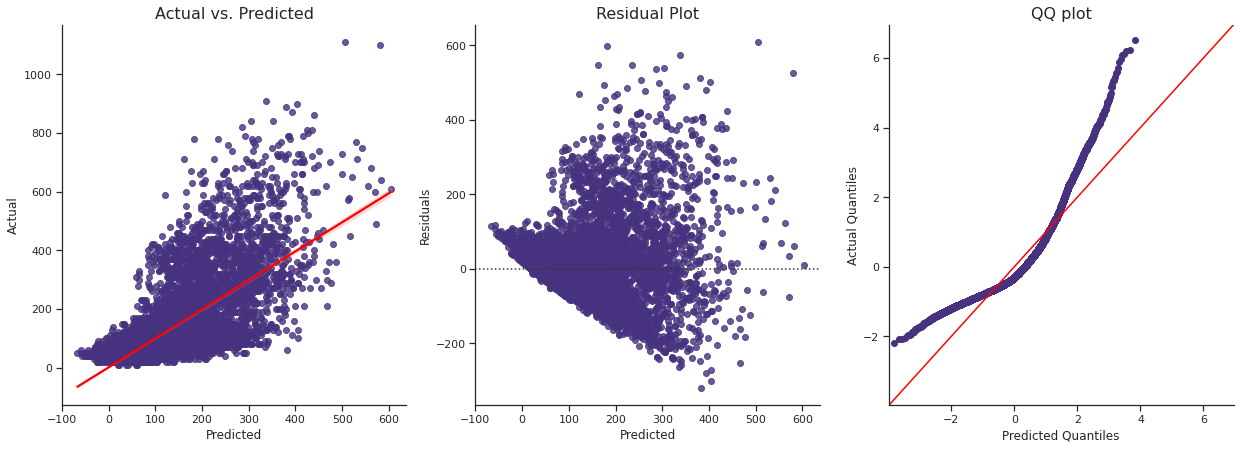

In [65]:
residual_plots(br_best, X, y)

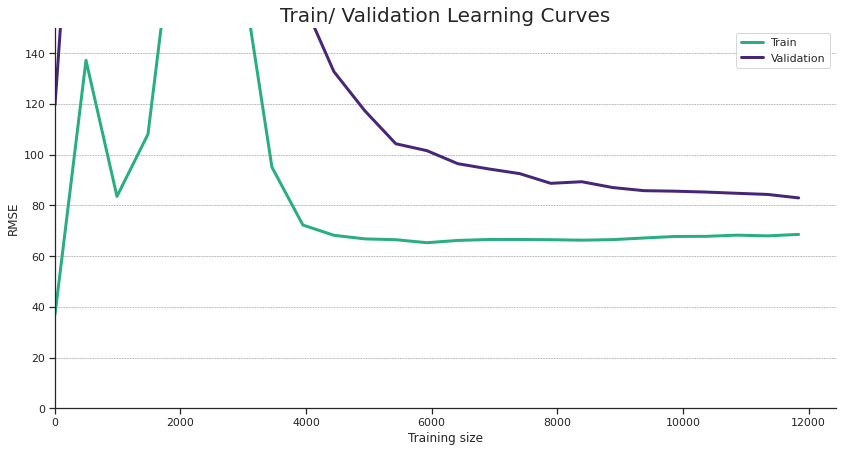

In [66]:
learning_curves(br_best, X, y)

Bagging the polynomial regressor didn't seem to improve on the performance of the original model significantly. It negatively impacted the efficiency of training the model and analysing the learning curves, it doesn't seem worth going down this path. The learning curve indicates that early stopping would be beneficial, as the training error starts to increase as training size increases. There are better models that could achieve this performance, more efficiently.

In [67]:
filename = 'models/br_best.sav'
joblib.dump(br_best, filename)

['models/br_best.sav']